# Snippet #2

In [1]:
from __future__ import print_function

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import csv
import numpy as np
from oddt import toolkit, random_seed
from oddt.scoring.functions.RFScore import rfscore
from oddt.scoring.models.regressors import randomforest, mlr, pls, neuralnetwork
from oddt.scoring import cross_validate
from oddt.datasets import pdbbind

### Define descriptor generator, using RF-Score settings

In [5]:
descriptor_generator = rfscore.load().descriptor_generator

### Import affinity data

In [6]:
# Import affinity data
p = pdbbind('v2007', version=2007, default_set='refined')
pdbbind_act_train = {pdbid: act for pdbid, act in p.sets['refined'].items() if pdbid not in p.sets['core']}
pdbbind_act_test = p.sets['core']

### Build training and testing descriptors

In [7]:
%%time
def gen_descriptors(pdbid):
    ligand = next(toolkit.readfile('sdf', 'v2007/%s/%s_ligand.sdf' % (pdbid, pdbid)))
    protein = next(toolkit.readfile('pdb', 'v2007/%s/%s_pocket.pdb' % (pdbid, pdbid)))
    return descriptor_generator.build([ligand], protein)

descriptors_train = np.vstack([gen_descriptors(pdbid) for pdbid in pdbbind_act_train.keys()])
descriptors_test = np.vstack([gen_descriptors(pdbid) for pdbid in pdbbind_act_test.keys()])

CPU times: user 2min 11s, sys: 79.3 ms, total: 2min 11s
Wall time: 2min 11s


### Validate all regressor models

Random Forest
Internal CV [R^2]: Train 0.9259 Test 0.5805
CV R^2_mean: 0.4885 R_std: 0.0289
Multiple Linear Regression
Internal CV [R^2]: Train 0.4109 Test 0.3603
CV R^2_mean: 0.3758 R_std: 0.0393
Partial Least Squares
Internal CV [R^2]: Train 0.0146 Test 0.0112
CV R^2_mean: 0.0145 R_std: 0.0062
Neural Network
Internal CV [R^2]: Train 0.2352 Test 0.1732
CV R^2_mean: -0.2085 R_std: 0.5604


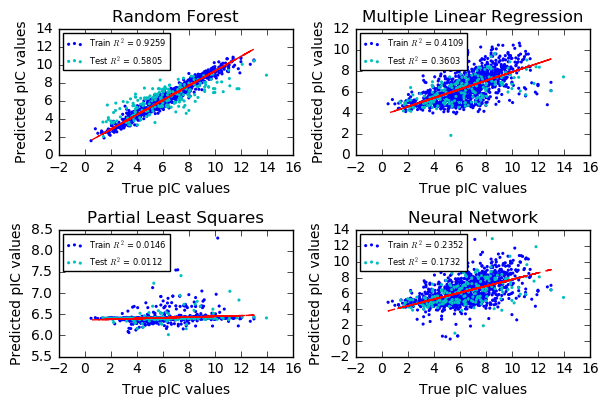

In [8]:
# Prepare plot
ax = {}
fig, ((ax['Random Forest'], 
       ax['Multiple Linear Regression']), 
      (ax['Partial Least Squares'], 
       ax['Neural Network'])) = plt.subplots(nrows=2, ncols=2)

random_seed(1)
models = [(randomforest(500), 'Random Forest'),
          (mlr(), 'Multiple Linear Regression'),
          (pls(), 'Partial Least Squares'),
          (neuralnetwork((5,)), 'Neural Network')]

# Validate all regressor models
for model, name in models:
    print(name)
    m = model.fit(descriptors_train, list(pdbbind_act_train.values()))
    r_train = m.score(descriptors_train, list(pdbbind_act_train.values()))
    r_test = m.score(descriptors_test, list(pdbbind_act_test.values()))
    print('Internal CV [R^2]: Train %.4f Test %.4f' % (r_train, r_test))
    
    cv_descs = np.vstack((descriptors_train, descriptors_test))
    cv_act = list(pdbbind_act_train.values()) + list(pdbbind_act_test.values())
    cv = cross_validate(m, cv_descs, cv_act , n=3)
    print('CV R^2_mean: %.4f R_std: %.4f' % (cv.mean(), np.std(cv)))
    
    # Train Set
    x_train = np.array(list(pdbbind_act_train.values()))
    y_train = m.predict(descriptors_train).flatten()
    ax[name].scatter(x_train, 
                     y_train, 
                     marker='.', 
                     edgecolors='none', 
                     c='b', 
                     label=r"Train $R^2$ = %.4f" % m.score(descriptors_train, 
                                                           list(pdbbind_act_train.values())))
    
    # Test Set
    x_test = np.array(list(pdbbind_act_test.values()))
    y_test = m.predict(descriptors_test).flatten()
    ax[name].scatter(x_test,
                     y_test,
                     marker='.',
                     edgecolors='none', 
                     c='c', 
                     label=r"Test $R^2$ = %.4f" % m.score(descriptors_test, 
                                                          list(pdbbind_act_test.values())))
    
    ax[name].plot(x_train, np.polyval(np.polyfit(x_train,y_train,1), x_train), '--r')
    ax[name].set_title(name)
    ax[name].legend(loc=2,prop={'size':6})
    ax[name].set_xlabel("True pIC values")
    ax[name].set_ylabel("Predicted pIC values")

# Save plot to file
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('Snippet_2.png', dpi=300)